In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("car_purchasing.csv", encoding="latin1")

data.head()

,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [3]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cols_ohe = ['country']

ohe_encoded = ohe.fit_transform(data[cols_ohe])

ohe_df = pd.DataFrame(
    ohe_encoded,
    columns=ohe.get_feature_names_out(cols_ohe),
    index=data.index
)

df = pd.concat([data.drop(columns=cols_ohe), ohe_df], axis=1)
df.head()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount,country_Algeria,country_American Samoa,country_Andorra,country_Angola,...,country_Venezuela,country_Viet Nam,"country_Virgin Islands, British","country_Virgin Islands, United States",country_Wallis and Futuna,country_Western Sahara,country_Yemen,country_Zimbabwe,country_marlal,country_Åland Islands
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = df.drop(columns=['car purchase amount'])
y = df['car purchase amount'] / 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

num_cols = ['age', 'annual Salary', 'credit card debt', 'net worth']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Convert to tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.values,  dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_torch  = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1)

batch_size = 128

train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds  = TensorDataset(X_test_torch,  y_test_torch)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [5]:
class CarNet(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
            # No activation — regression outputs a raw value
        )

    def forward(self, x):
        return self.net(x)


inp_dim = X_train_torch.shape[1]

model     = CarNet(input_dim=inp_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# Early stopping — equivalent of tf.keras.callbacks.EarlyStopping
# Tracks val_loss and stops training if it doesn't improve for 'patience' epochs
# restore_best_weights=True means we reload the best checkpoint at the end

class EarlyStopping:

    def __init__(self, patience=20):
        self.patience   = patience
        self.best_loss  = float('inf')
        self.counter    = 0
        self.best_weights = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss    = val_loss
            self.counter      = 0
            self.best_weights = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1

        return self.counter >= self.patience

    def restore(self, model):
        model.load_state_dict(self.best_weights)


es = EarlyStopping(patience=20)

In [7]:
num_epochs   = 2000
train_losses = []
val_losses   = []

for epoch in range(num_epochs):

    model.train()
    train_loss_sum = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss_sum += loss.item() * xb.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    stop = es.step(epoch_val_loss, model)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} / {num_epochs} | Train {epoch_train_loss:.4f} | Val {epoch_val_loss:.4f}")

    if stop:
        print(f"\nEarly stopping at epoch {epoch+1} | Best val loss: {es.best_loss:.4f}")
        break

# Restore best weights
es.restore(model)

Epoch 100 / 2000 | Train 38.3691 | Val 52.1754

Early stopping at epoch 188 | Best val loss: 41.9178


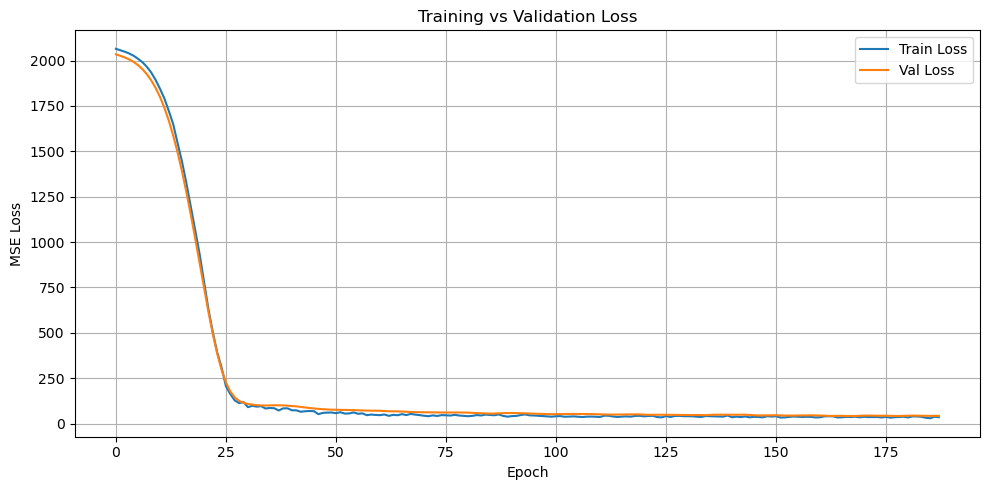

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses,   label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

RMSE : 6.4744k
MAE  : 4.8218k


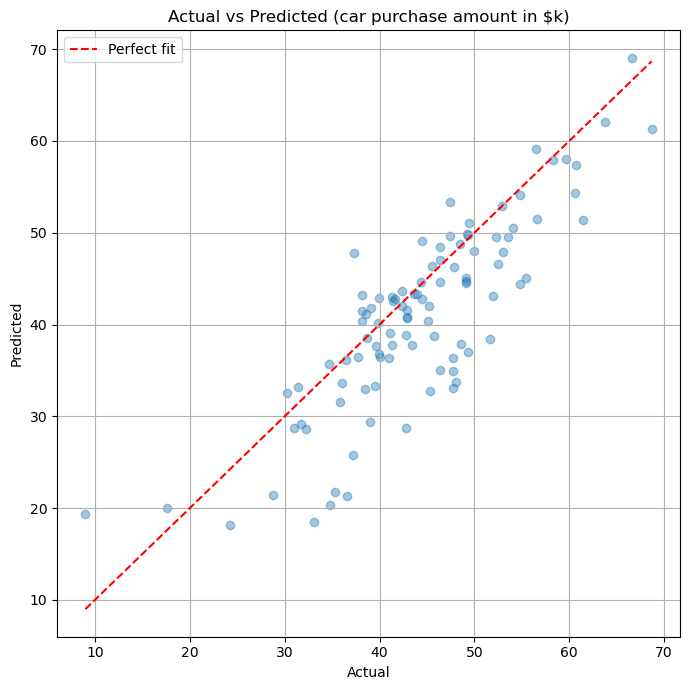

In [9]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).squeeze().numpy()

y_true = y_test_torch.squeeze().numpy()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print(f"RMSE : {rmse:.4f}k")
print(f"MAE  : {mae:.4f}k")

# Actual vs Predicted scatter plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y_true, y_pred, alpha=0.4)
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect fit')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted (car purchase amount in $k)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()